In [ ]:
# If you didn't install these packages, run these cells.
!pip install soynlp
!pip install konlpy

from soynlp.normalizer import *
import soynlp

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 416 kB 5.3 MB/s 
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 49.0 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Experiment : LSTM model

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/cose461/data_100.csv')
df.head(10)

,index,utterance,P_gender
0,"('9fdbaeb2-3f1a-5ba2-a6a6-53d9a57fd33d', 'P02')",학교 6일에감 내일가냐? 불썅 ㅇㅎㅇㅎ ㅇㅇㅇㅇ왜안산에있어 다1교시얔ㅋㅋ,0
1,"('3fb66713-37a2-50e5-9b0a-afb898c06eea', 'P02')","천처니 오십셔,, 한 다섯시 맞춰서 오면 되지않으까 싶네욤 ㅎㅎ 흑흑 보고파 오뤼 ...",0
2,"('642fd586-be49-5bd9-b596-ccb2c8badab6', 'P02')",ㅋㅋㅋㅋㅋㅋㅋ 더워? 하긴여기도 그렇게안추워 ㅋㅋㅋㅋㅋㅋ벌써마지막이야?? 오늘 하루...,0
3,"('b8d86fc3-2154-562c-b8d6-bb566d72fa4f', 'P02')",딱히읍지 나야 왜?? 인스타보니까 놀러가신거? 13일에 오는거야? 구래 볼수있늠 보...,0
4,"('ce82e17c-5730-5ed4-8bf9-40eac1f5d99a', 'P01')","속초에 월, 화 비온다고 되어있는데 화부턴 날씨가 추워지더라고 2도 내생각엔 오빠 ...",0
5,"('c4cda8af-f443-5add-9c5d-c17859c975ae', 'P01')",근데 커피를 저기다가 흘릴일이없거든 ... ㅋㅋㅋㅋ 배고프당 너무너무너무너무 나 지...,0
6,"('a700867e-3173-5b98-b6fb-f8648d6d7fea', 'P02')",아니~ 단식원은 가본적 없어 단식원을 왜 가~ 가서 고생만 해 어차피 그런거는 다시...,0
7,"('d40c6bef-e632-5a8c-b2ac-2e910f8b3bf6', 'P02')","제관 팀플장소 차서 카퍼ㅣ드림 왔어 아이쿠,, 글게말야 ㅋㅋㅋㅋㅋㄱ 있오 나 수업 ...",0
8,"('93ba610a-57ed-5d0e-991e-1698ebeebb51', 'P02')",주말 평일은 시간없는뎅 토욜밖에안됨 ㅇㅇ 나도 그때 제본이랑 짐정리해야됨,0
9,"('9bd9dfd5-e432-5d15-aaff-17a3c2cdf440', 'P01')",한번 배워보고싶긴하다 오빠한테 물어봐야겠네 아~ 카페에서 커피 여유롭게 마시고싶다 ...,0


## data pre-processing

In [ ]:
from soynlp.normalizer import *
from konlpy.tag import Okt
import re

okt = Okt()

def clean(doc) :

  new_doc = list()
  doc = okt.pos(doc, norm=True)

  stop_tags = ['Determiner', 'Josa', 'Foreign']
  stop_words = ['은', '는', '이', '가', '', '이름', '계정', '주소', '신원', '전번', '금융', '번호', '소속', '기타']
  for text, tag in doc:  

    if tag in stop_tags:
      continue

    text = re.sub(r'[^ㄱ-ㅣ가-힣?.!~\^]+', '', text)  # remove digits.  
    text = emoticon_normalize(text, num_repeats=2) # remove repeated emoticon. e.g) ㅋㅋㅋㅋ=>ㅋㅋ, ㅠㅠㅠㅠ=>ㅠㅠ
    text = repeat_normalize(text, num_repeats=1) # remove repeated character
    
    if text in stop_words or (tag=='Verb' and len(text)<=1):
      continue
      
    new_doc.append(text)

  return new_doc

In [ ]:
df['sents'] = df['utterance'].apply(clean)

### train, test data 만들기 및 정수 인코딩

In [ ]:
X = df['sents']
y = df['P_gender']

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)

print(len(X_train))
print(len(y_train))

800388
800388


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)     # data 적게 할 때는 division by zero 나올수도
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 597233
등장 빈도가 2번 이하인 희귀 단어의 수: 427538
단어 집합에서 희귀 단어의 비율: 71.58646625353924
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.374021745163459


In [ ]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 169696


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

### 빈 데이터 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

800143
800143


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 패딩

메시지의 최대 길이 : 1215
메시지의 평균 길이 : 25.719396407892088


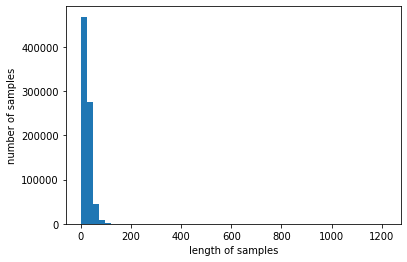

In [ ]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(50,X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 93.4512955809149


In [ ]:
max_len = 50
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 모델 정의 및 train

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import L2, L1

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [ ]:
embedding_dim = 100
hidden_units = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [ ]:
embedding_dim = [50, 100, 150]
hidden_units = [64, 128, 256]
dropout_probability = [0, 0.2]
n_iter = 1
for e in embedding_dim :
  for h in hidden_units :
    for d in dropout_probability :
      model = Sequential()
      model.add(Embedding(vocab_size, e))
      model.add(LSTM(h))
      model.add(Dropout(d))
      model.add(Dense(1, activation='sigmoid'))

      print("============{} iteration ============".format(n_iter))
      print("embedding_dim : {}, hidden_units : {}, dropout_prob : {}".format(e, h, d))
      model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
      history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2) 
      loaded_model = load_model('best_model.h5')
      print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
      print('====================================')
      n_iter += 1

============1 iteration ============
embedding_dim : 50, hidden_units : 64, dropout_prob : 0
Epoch 1/15
10002/10002 [==============================] - 202s 20ms/step - loss: 0.5886 - acc: 0.6814 - val_loss: 0.5800 - val_acc: 0.6908
Epoch 2/15
10002/10002 [==============================] - 188s 19ms/step - loss: 0.5463 - acc: 0.7187 - val_loss: 0.5642 - val_acc: 0.7020
Epoch 3/15
10002/10002 [==============================] - 194s 19ms/step - loss: 0.5092 - acc: 0.7475 - val_loss: 0.5699 - val_acc: 0.7019
Epoch 4/15
10002/10002 [==============================] - 186s 19ms/step - loss: 0.4841 - acc: 0.7651 - val_loss: 0.5844 - val_acc: 0.6996
Epoch 00004: early stopping
6254/6254 [==============================] - 40s 6ms/step - loss: 0.5629 - acc: 0.7029

 테스트 정확도: 0.7029
============2 iteration ============
embedding_dim : 50, hidden_units : 64, dropout_prob : 0.2
Epoch 1/15
10002/10002 [==============================] - 196s 19ms/step - loss: 0.5898 - acc: 0.6808 - val_loss: 0.5792 - 

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
10000/10002 [============================>.] - ETA: 0s - loss: 0.5875 - acc: 0.6824
Epoch 00001: val_acc improved from -inf to 0.69867, saving model to best_model.h5
10002/10002 [==============================] - 190s 18ms/step - loss: 0.5875 - acc: 0.6824 - val_loss: 0.5707 - val_acc: 0.6987
Epoch 2/15
10000/10002 [============================>.] - ETA: 0s - loss: 0.5353 - acc: 0.7276
Epoch 00002: val_acc improved from 0.69867 to 0.70733, saving model to best_model.h5
10002/10002 [==============================] - 187s 19ms/step - loss: 0.5353 - acc: 0.7276 - val_loss: 0.5600 - val_acc: 0.7073
Epoch 3/15
10000/10002 [============================>.] - ETA: 0s - loss: 0.4974 - acc: 0.7554
Epoch 00003: val_acc did not improve from 0.70733
10002/10002 [==============================] - 185s 19ms/step - loss: 0.4974 - acc: 0.7554 - val_loss: 0.5631 - val_acc: 0.7029
Epoch 4/15
10000/10002 [============================>.] - ETA: 0s - loss: 0.4635 - acc: 0.7783
Epoch 00004: val_ac

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

6254/6254 [==============================] - 40s 6ms/step - loss: 0.5582 - acc: 0.7093

 테스트 정확도: 0.7093
